# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<a id='content'></a>


<div> 

**Содержание**:

* <a href='#know_the_data'>Знакомство с данными</a> </br>          
* <a href='#data_preprocessing'>Предобработка данных</a> </br>     
* <a href='#data_analysis'>Анализ данных</a> </br>                 
* <a href='#research_of_models'>Исследование моделей</a> </br>     
* <a href='#testing'>Тестирование</a></br>                        
* <a href='#conclusions'>Выводы</a></br>                          


</div>


## Знакомство с данными

 <a id='know_the_data'></a>

### Библиотеки и функции

In [1]:
!pip install scikit-learn -q

In [2]:
!pip install pandas seaborn numba numpy matplotlib -q

In [3]:
!pip install phik -q

In [4]:
!pip install missingno -q

In [5]:
!pip install jinja2==3.1.2 -q

In [6]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings
import sklearn
import math
import missingno as msno
import re
import phik
import time

from numpy import mean
from numpy import std


from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import (MinMaxScaler, LabelEncoder, 
                                   OneHotEncoder, OrdinalEncoder, 
                                   StandardScaler, RobustScaler)
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [7]:
# Функция для построения гистограмм
def plot_histograms(df, columns, rows=2):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, 
                             ncols=cols, 
                             figsize=(cols*5, rows*4))
    axes = axes.flatten()  

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета, 
#file_name - строка с названием файла для загрузки, 
#df_name - название для загружаемого датасета
#sep - разделитель, по умолчанию ','
#graf - строим ли графики

def loading_data(file_name, 
                 df_name, sep=',', 
                 graf=True, missingno=False, 
                 figsize=(15,10), bins=30):
    
    try:
        df = pd.read_csv('assets/'+  file_name, sep=sep) 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep) 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, \
          столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце')
    print()
    display(pd.DataFrame(df.isna().mean()*100).round(2)
            .style.background_gradient('coolwarm'))
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (8,6))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'NumberOfPictures' in df.columns:
            df_new = df.drop(columns=['NumberOfPictures'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/3)
        plot_histograms(df_new, numeric_cols, rows=rows)  # Например, 3 ряда
        
        #g.fig.set_size_inches(figsize)
        
        plt.show()
        #label = 'Гистограмма распределения '+ my_title
        #plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')  
        #sns.set_context(rc={'legend.fontsize': 24})
          

    return df

In [8]:
'''
Исследовательский анализ данных
Гистограмма и ящик с усами
data - series
title - название для графика
'''
def my_plot(data,x_column, 
            #hue_column,
            my_title, bins=50):
    
    my_plot = sns.histplot(data, 
                           x=data[x_column], 
                           #hue=hue_column, 
                           bins=50, 
                           palette="Set1", 
                           linewidth=0.3, 
                           kde=True, 
                           legend=True)
    label = 'Гистограмма распределения '+ my_title
   
    my_plot.set_title(label=label, 
                      fontsize = 16, 
                      y = 1, 
                      color = 'midnightblue')
    plt.grid(True)
    plt.ylabel('Количество', fontsize = 16)
    plt.legend()
    
 
    
    
def my_boxplot(data, my_title):
    # постройте ящик с усами целевого признака с горизонтальной ориентацией
    label = 'График ящик с усами для ' + my_title
    plt.title(label, fontsize = 16, y = 1, color='midnightblue')
    plt.boxplot(data, vert=False)
    plt.grid(True)

In [9]:
#Предобработка, удаление явных дубликатов
def remove_duplicates(data, title):
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        print('Количество явных дубликатов в ', title, ':', data.duplicated()
              .sum())
        print('Размер', title, 'до удаления дубликатов:', data.shape)
        data = data.drop_duplicates(keep = 'first', 
                                    subset=data.columns.difference(['id']))
        print('Размер', title, 'после удаления дубликатов:', data.shape)
        return data
    else:
        print('Явные дубликаты в', title, 'отсутсвуют')
        return data

In [10]:
def execution_time(start_time):
    end_time = time.time()  # запоминаем время окончания выполнения функции

    execution_time = end_time - start_time  # вычисляем время выполнения функции
    print(f"{round(execution_time, 2)} секунд")
    return round(execution_time, 2)

<a href='#content'>Вернуться к оглавлению</a> 

### Знакомство с данными

df


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс,           столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated    

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


--------------------------------------------------------------------------------
Визуализируем пропуски в данных


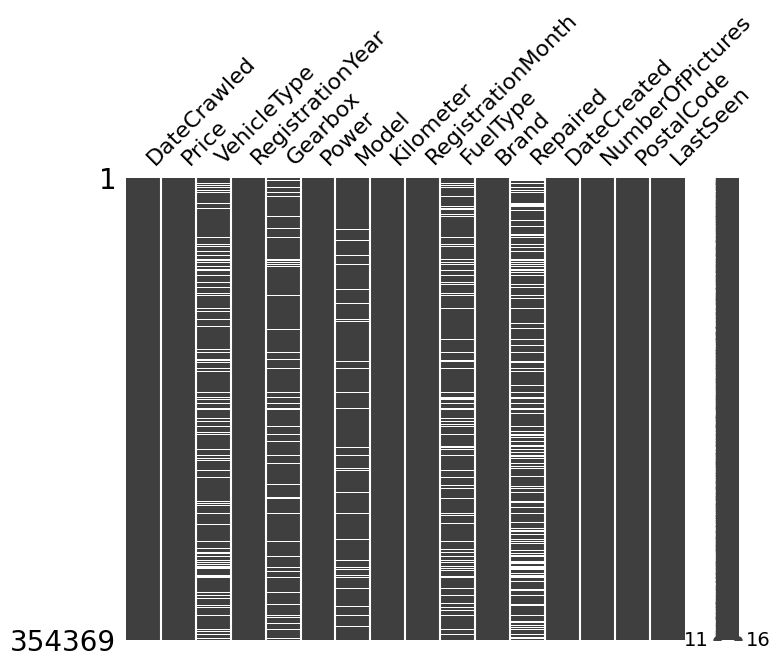

--------------------------------------------------------------------------------
Визуализируем общие данные


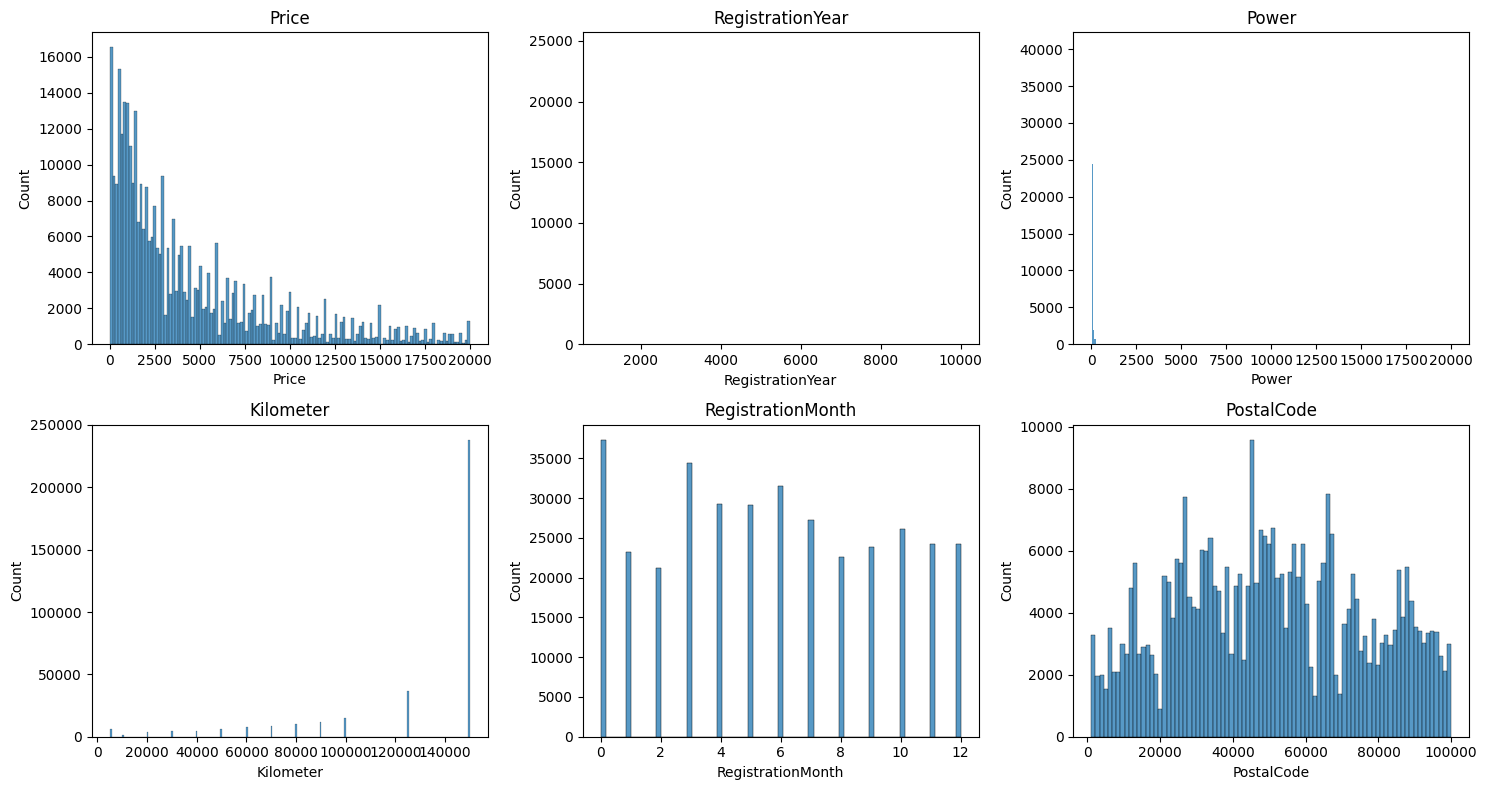

In [11]:
df = loading_data('autos.csv', 'df', missingno=True)

In [12]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1. Минимальная цена 0 - неправдободобна, подобные записи необходимо удалить из датасета. 
2. Минимальные и максимальные значения года регистрации указывают на ошибку ввода данных. (Необходимо удалить)
3. Мощность автомобиля 0 л.с. может указывать на то, что продавец не владеет информацией по данному пункту. Оставим данные строки, а вот максимальное значение явно имеет выбросы, т.к. с указанными значениями автомобилей не существует.
4. Столбец с количеством фото имеет одно единственное значение ноль, не информативен и будет удален.

**Промежуточные выводы**
- Данные содержат пропуски
- Есть выбросы
- Названия столбцов не соответсвуют стандарту snake_case
- Для столбцов с датой необходимо изменить тип данных

<a href='#content'>Вернуться к оглавлению</a> 

## Предобработка данных

<a id='data_preprocessing'></a>

Проверим данные на наличие явных дубликатов и при нахождении избавимся от них.

In [13]:
df = remove_duplicates(df, 'df')

Количество явных дубликатов в  df : 4
Размер df до удаления дубликатов: (354369, 16)
Размер df после удаления дубликатов: (354365, 16)


In [14]:
# Приведем названия столбцов к стандарту snake_case
df.columns = [re.sub(r'(?<!^)(?=[A-Z])','_', i).lower() for i in df.columns]
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропуски в признаках:
- vehicle_type — тип автомобильного кузова
- gearbox — тип коробки передач
- model — модель автомобиля
- fuel_type — тип топлива
- repaired — была машина в ремонте или нет



In [15]:
df_original = df

In [16]:
print('Количество пропусков:')
df[['vehicle_type', 'fuel_type', 'repaired', 'gearbox', 'model']].isna().sum()

Количество пропусков:


vehicle_type    37490
fuel_type       32895
repaired        71154
gearbox         19833
model           19705
dtype: int64

Посмотрим на распределение уникальных значений в категориальных признаках, для того чтобы выбрать оптимальный способ заполнения пропусков

In [17]:
vehicle_type = df['vehicle_type'].value_counts()
fuel_type = df['fuel_type'].value_counts()
repaired = df['repaired'].value_counts()
gearbox = df['gearbox'].value_counts()

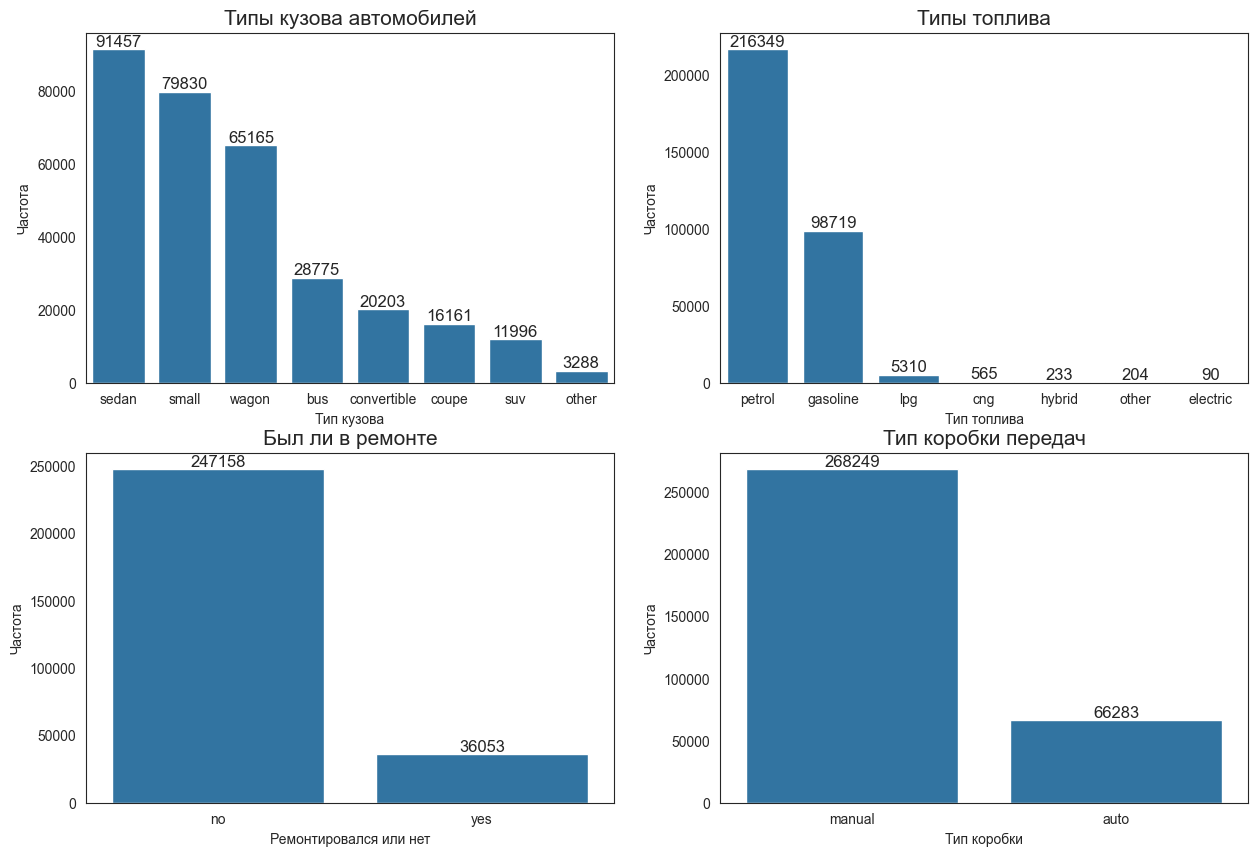

In [18]:
fig = plt.figure(figsize = (15,10))
sns.set_style('white')
ax_1 = fig.add_subplot(2,2,1)
sns.barplot(x=vehicle_type.index, y=vehicle_type.values) 
ax_1.bar_label(ax_1.containers[0], fontsize=12)
ax_1.set_title('Типы кузова автомобилей', fontsize = 15)
ax_1.set_xlabel('Тип кузова') 
ax_1.set_ylabel('Частота')

ax_2 = fig.add_subplot(2,2,2)
sns.barplot(x=fuel_type.index, y=fuel_type.values) 
ax_2.bar_label(ax_2.containers[0], fontsize=12)
ax_2.set_title('Типы топлива', fontsize = 15)
ax_2.set_xlabel('Тип топлива') 
ax_2.set_ylabel('Частота')

ax_3 = fig.add_subplot(2,2,3)
sns.barplot(x=repaired.index, y=repaired.values) 
ax_3.bar_label(ax_3.containers[0], fontsize=12)
ax_3.set_title('Был ли в ремонте', fontsize = 15)
ax_3.set_xlabel('Ремонтировался или нет') 
ax_3.set_ylabel('Частота')

ax_4 = fig.add_subplot(2,2,4)
sns.barplot(x=gearbox.index, y=gearbox.values) 
ax_4.bar_label(ax_4.containers[0], fontsize=12)
ax_4.set_title('Тип коробки передач', fontsize = 15)
ax_4.set_xlabel('Тип коробки') 
ax_4.set_ylabel('Частота')

plt.show()

Пропуски в vehicle_type, fuel_type заменим на значением 'other', в gearbox, model, repaired на 'unknown'

In [19]:
df[['vehicle_type', 'fuel_type']] = df[['vehicle_type', 
                                        'fuel_type']].fillna('other')
df[['gearbox', 'model', 'repaired']] = df[['gearbox', 
                                           'model', 
                                           'repaired']].fillna('unknown')
print('Количество пропусков:')
df[['vehicle_type', 'fuel_type', 'gearbox', 'model', 'repaired']].isna().sum()

Количество пропусков:


vehicle_type    0
fuel_type       0
gearbox         0
model           0
repaired        0
dtype: int64

В данных присутсвуют выбросы:
- registration_year — год регистрации автомобиля
- power — мощность (л. с.)
- price - стоимость автомобиля 


В 2016 году самым мощным серийным автомобилем был Bugatti Chiron, мощность 1500 лошадиных сил.

Однако важно отметить, что Bugatti Chiron - это гиперкар, а не массовый автомобиль.

Если говорить о массовых автомобилях, то в 2016 году можно выделить несколько моделей с высокой мощностью:

Dodge Viper ACR: 8,4-литровый двигатель V10 мощностью 645 лошадиных сил.
Chevrolet Corvette Z06: 6,2-литровый двигатель V8 мощностью 650 лошадиных сил.
Ford Shelby GT350 Mustang: 5,2-литровый двигатель V8 мощностью 526 лошадиных сил.
Таким образом **сверху ограничим мощность автомобилей 650 л.с.**

Модель T от Ford, которая стала первым массовым автомобилем в 1908 году, оснащалась двигателем мощностью около 20 лошадиных сил.

Поэтому **снизу ограничим мощность 20 л.с.**, а год выпуска **1945 годом.** 

В 2016 году средняя стоимость утилизации автомобиля в Европе составляла 50–200 евро, поэтому оставим минимальную стоимость не ниже данного порога.


In [20]:
df= df.query('registration_year >= 1945 and registration_year <= 2025')
   
df = df.loc[df['power'] <= 650]  
df = df.loc[df['power'] >=20]
df = df.loc[df['price'] > 50]  
print('Датасет до удаления выбросов:', df_original.shape)
print('Датасет после удаления выбросов:', df.shape)
print('Удалено:', round((len(df_original)-len(df))/len(df)*100, 2) ,'%')

Датасет до удаления выбросов: (354365, 16)
Датасет после удаления выбросов: (305476, 16)
Удалено: 16.0 %


In [21]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


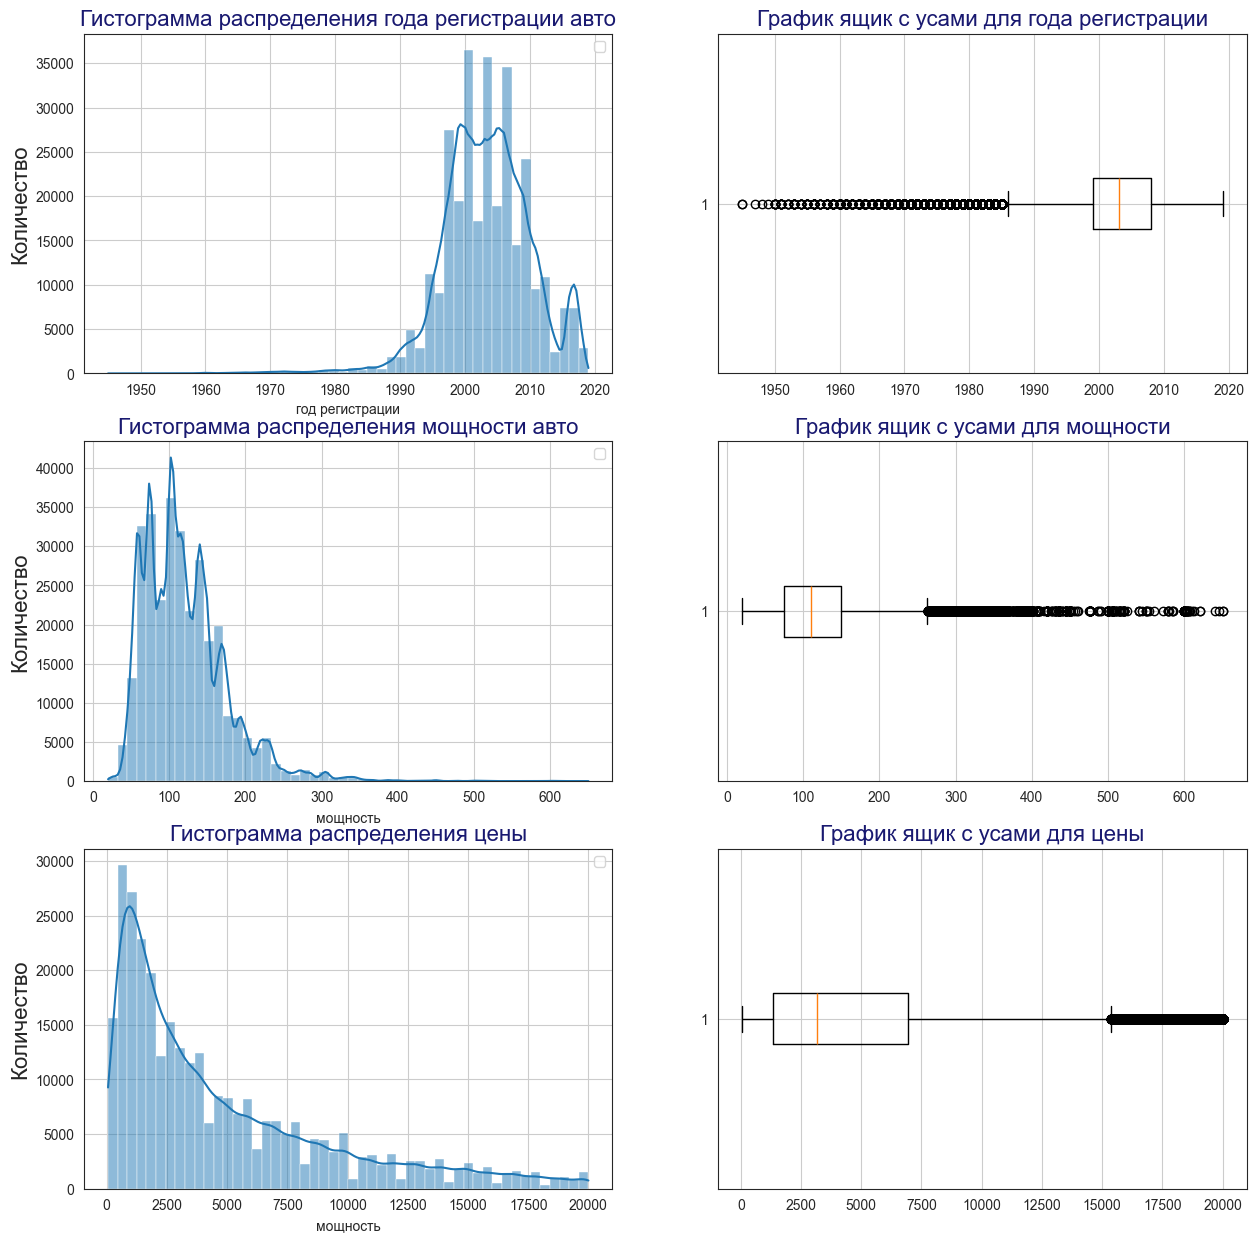

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
my_plot(data = df, 
        x_column='registration_year', 
        #hue_column='brand', 
        my_title='года регистрации авто', 
        bins=50)

plt.xlabel('год регистрации')

plt.subplot(3, 2, 2)
my_boxplot(df['registration_year'], 'года регистрации')

plt.subplot(3, 2, 3)
my_plot(data = df, 
        x_column='power', 
        #hue_column='brand', 
        my_title='мощности авто', 
        bins=50)

plt.xlabel('мощность')

plt.subplot(3, 2, 4)
my_boxplot(df['power'], 'мощности')

plt.subplot(3, 2, 5)
my_plot(data = df, 
        x_column='price', 
        #hue_column='brand', 
        my_title='цены', 
        bins=50)

plt.xlabel('мощность')

plt.subplot(3, 2, 6)
my_boxplot(df['price'], 'цены')

Ящики с усами имеют значения за пределами "усов", но данные точки не обязательно относятся к выбросам, а могут представлять аномальные значения.

<function matplotlib.pyplot.show(close=None, block=None)>

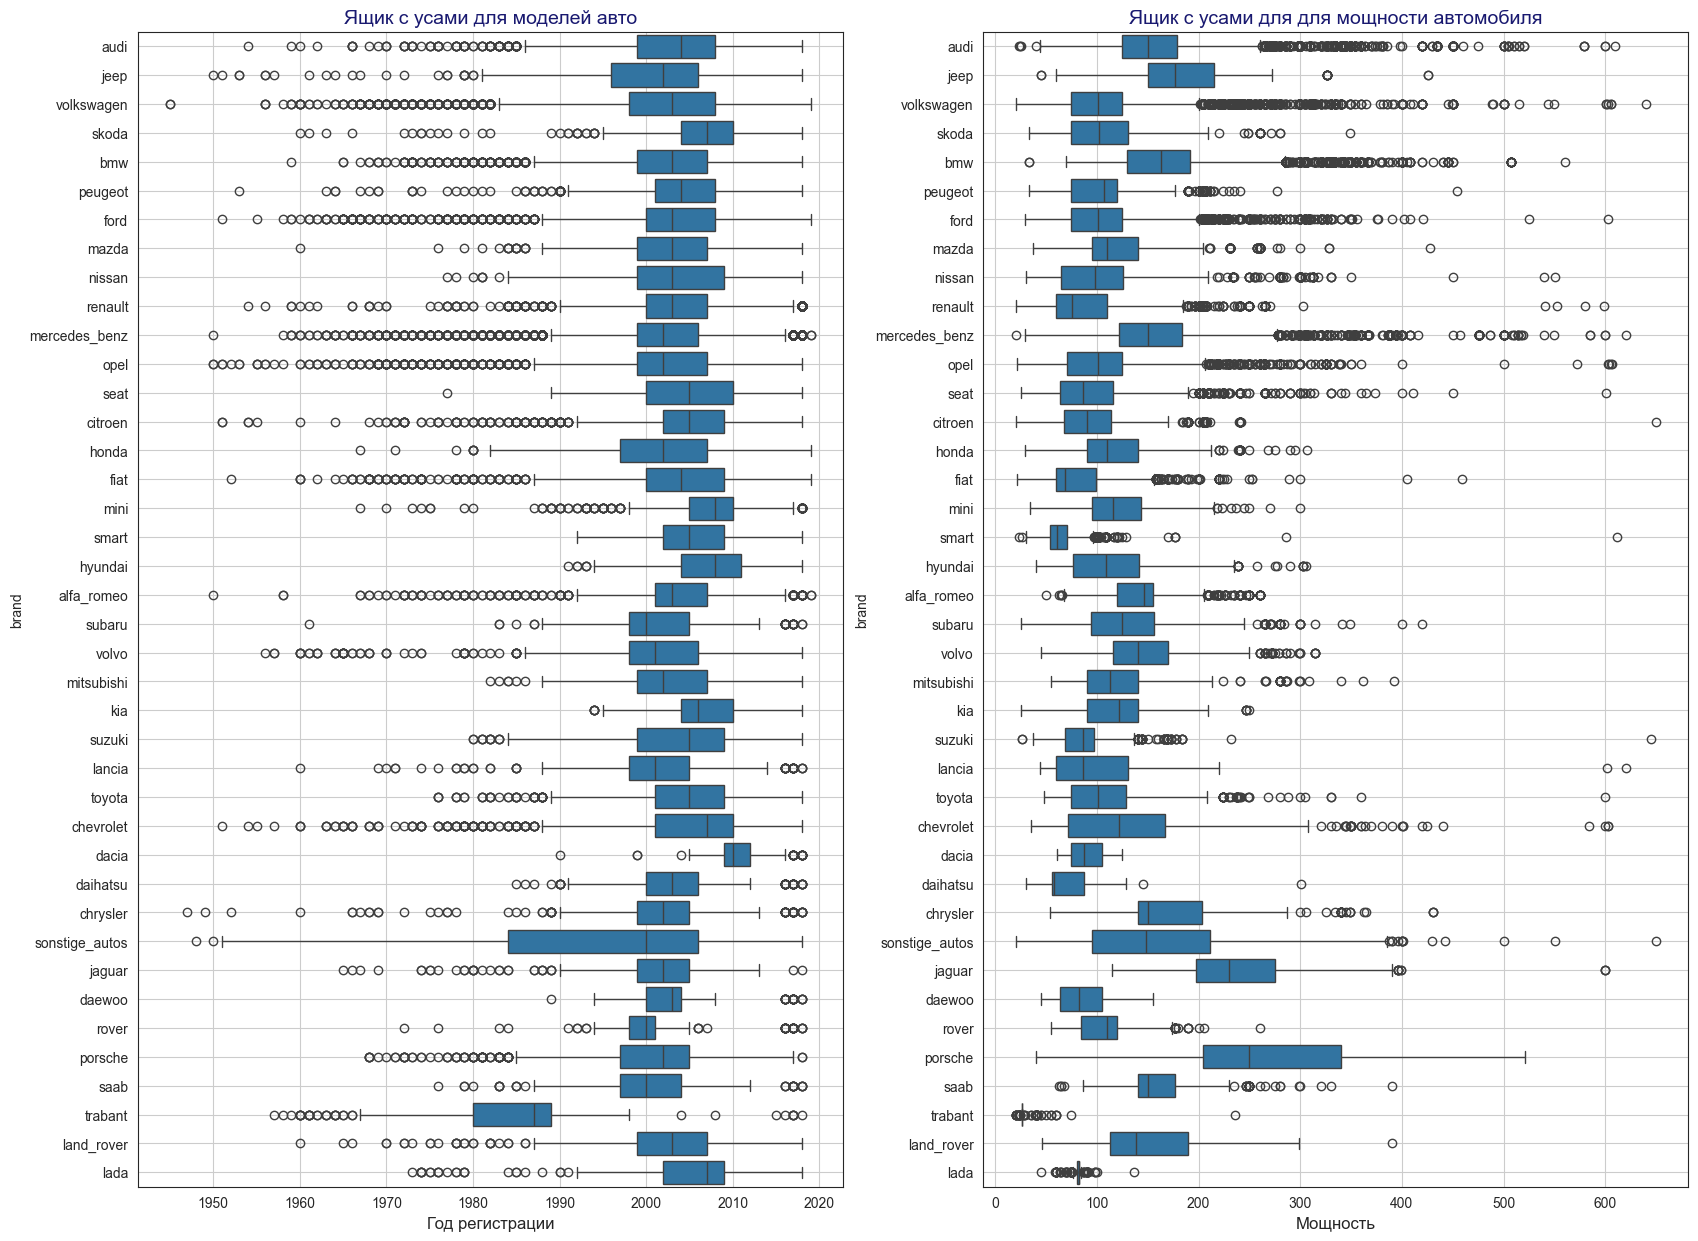

In [23]:
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['registration_year'],
            y=df['brand'], orient='h')
plt.grid(True)
label = 'Ящик с усами для моделей авто'
plt.title(label, fontsize = 14, y = 1, color='midnightblue')
plt.xlabel('Год регистрации', fontsize = 12)

plt.subplot(1, 2, 2)
sns.boxplot(x=df['power'],
            y=df['brand'], orient='h')
plt.grid(True)
label = 'Ящик с усами для для мощности автомобиля'
plt.title(label, fontsize = 14, y = 1, color='midnightblue')
plt.xlabel('Мощность', fontsize = 12)
plt.show

Ящики с усами показывают наличие данных за пределами 1.5 стандартных отклонений. Это могут быть как выбросы (ошибочно завышена мощность автомобиля на порядок или указан неверный год выпуска), но это могут быть и аномальные значения: ретрокары и суперкары.


Столбец с количеством изображений содержит единсвенное значение - ноль, удалим этот признак, т.к. он не информативен. 

In [24]:
print('Размер датасета до удаления признака:', df.shape)
df=df.drop(columns=['number_of_pictures'])
print('Размер датасета после удаления признака:', df.shape)

Размер датасета до удаления признака: (305476, 16)
Размер датасета после удаления признака: (305476, 15)


Проверим данные на скрытые дубликаты

In [25]:
print(f"Всего уникальных значений: {len(df['brand'].unique())}")
df['brand'].unique()

Всего уникальных значений: 40


array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

Исторические связи:

Land Rover (принадлежит Tata Motors) и Rover (прекратил существование).

Daewoo (поглощен GM, сейчас часть Chevrolet).

Saab и Trabant — прекратившие существование бренды.

Категория "sonstige_autos":

Это обобщающий термин для "прочих автомобилей", а не конкретный бренд.

Итог: Формально дубликатов в списке нет, так как все перечисленные названия — уникальные бренды. Однако если учитывать корпоративную принадлежность, некоторые марки связаны через холдинги, но это не делает их дубликатами. 
**Но раз в замечаниях просят приравнять Land Rover и Rover , так и сделаем**

In [26]:
df['brand'] = df['brand'].replace('rover', 'land_rover')
print(f"Всего уникальных значений: {len(df['brand'].unique())}")
df['brand'].unique()

Всего уникальных значений: 39


array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'land_rover', 'porsche',
       'saab', 'trabant', 'lada'], dtype=object)

In [27]:
df['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [28]:
print(f"Всего уникальных значений: {len(df['fuel_type'].unique())}")
df['fuel_type'].unique()

Всего уникальных значений: 7


array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

gasoline и petrol: В русском языке и в большинстве стран Европы это синонимы, обозначающие бензин.
lpg и cng: Это также разные виды газового топлива, но их часто объединяют под общим понятием "газ".
Объединим данные названия

In [29]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline', 'cng'], 
                                          ['petrol', 'lpg'])
print(f"Всего уникальных значений: {len(df['fuel_type'].unique())}")
df['fuel_type'].unique()

Всего уникальных значений: 5


array(['petrol', 'other', 'lpg', 'hybrid', 'electric'], dtype=object)

In [30]:
print(f"Всего уникальных значений: {len(df['model'].unique())}")
df['model'].unique()

Всего уникальных значений: 250


array(['unknown', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'one',
       'fortwo', '1er', 'b_klasse', 'a8', 'jetta', 'astra', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'ka', 'a1', 'focus', 'a4', 'tt',
       'a6', 'jazz', 'omega', 'slk', '7er', 'combo', 'corsa', '80', '147',
       'z_reihe', 'sportage', 'sorento', 'ibiza', 'mustang', 'eos',
       'touran', 'getz', 'insignia', 'almera', 'megane', 'a3', 'lupo',
       'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'i_reihe', '6_reihe', 'panda', 'up', 'ceed',
       'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'rio',
       'touareg', 'log

В данном списке присутствуют неявные дубликаты, связанные с разными вариантами обозначений серий/поколений автомобилей. Вот основные группы:

1er ↔ 1_reihe

3er ↔ 3_reihe ↔ 3_reihe ↔ serie_3

5er ↔ 5_reihe

6er ↔ 6_reihe

2_reihe ↔ serie_2



In [31]:
df['model'] = df['model'].replace(['1_reihe', 
                                    '3_reihe', 
                                    '5_reihe', 
                                    '6_reihe', 
                                    '2_reihe', 
                                    '3_reihe', 
                                    'serie_3'], 
                                    ['1er', 
                                    '3er', 
                                    '5er', 
                                    '6er', 
                                    'serie_2', 
                                    '3er', 
                                    '3er' ])


In [32]:
print(f"Всего уникальных значений: {len(df['model'].unique())}")

Всего уникальных значений: 244


In [33]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])
df[['date_crawled', 'date_created', 'last_seen']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 305476 entries, 1 to 354368
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_crawled  305476 non-null  datetime64[ns]
 1   date_created  305476 non-null  datetime64[ns]
 2   last_seen     305476 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 9.3 MB


**ВЫВОДЫ**

- Название признаков приведено к стандарту snake_case
- Пропуски заполнены
- Выбросы обработаны
- Неявные дубликаты обработаны
- Удален неинформативный признак NumberOfPictures — количество фотографий автомобиля
- Столбцы с датой приведены к нужному формату, синтезирован новый признак  (год продажи автомобиля)

<a href='#content'>Вернуться к оглавлению</a> 

<a id='data_analysis'></a>

## Анализ данных

Для выбора модели машинного обучения и входных признаков, посмотрим на корреляционную зависимость признаков.

Столбцы с временем переведем в число, синтезируем новый признак ('year' - год продажи автомобиля)

In [34]:
df['year'] = df['date_created'].dt.year
df['date_created_int'] = df['date_created'].dt.strftime("%Y%m%d%H%M%S") \
    .astype(int)
df['last_seen_int'] = df['last_seen'].dt.strftime("%Y%m%d%H%M%S").astype(int)
df['date_created_year'] = df['date_created'].dt.year


In [35]:
corr = df[['price',
           'registration_year',
           'power', 
           'kilometer',
           'registration_month',
           'postal_code',
           'vehicle_type', 
            'gearbox', 
            'model', 
            'fuel_type', 
            'brand', 
            'repaired',
            'date_created_int',
            'year',
            'last_seen_int',
            'date_created_year']].phik_matrix(interval_cols=['price',
                                                'registration_year', 
                                                'power', 
                                                'kilometer',
                                                'registration_month',
                                                'year',
                                                'postal_code',
                                                'date_created_int',
                                                'decision time',
                                                'last_seen_int',
                                                'date_created_year'])

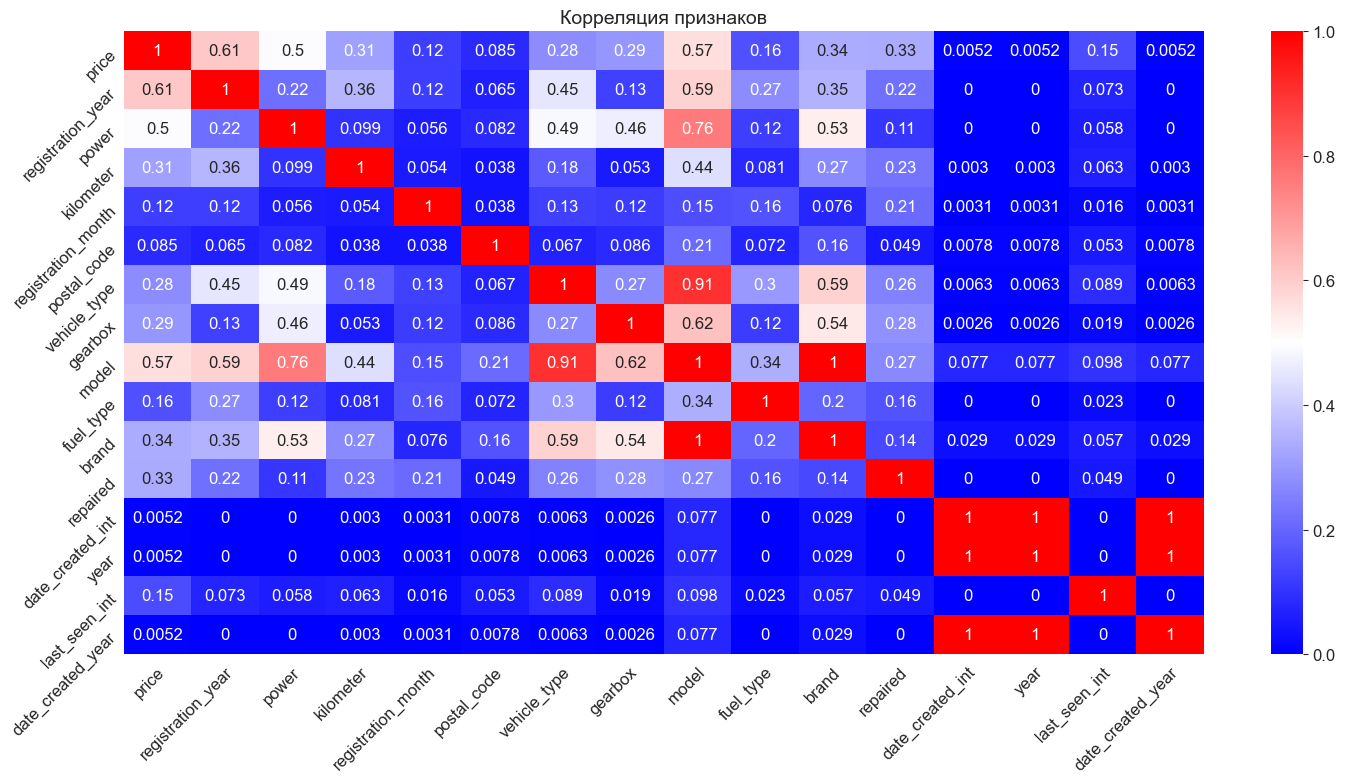

In [36]:
plt.figure(figsize=(15,8))
plt.rcParams['font.size'] = 12
plt.subplot()
ax = sns.heatmap(corr, annot=True, cmap='bwr')
plt.setp(ax.get_xticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
plt.setp(ax.get_yticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
ax.set_title("Корреляция признаков", fontsize=14)

plt.tight_layout()
plt.show()

Из таблицы корреляции можно заметить, что между:
- 'date_created_int',
- 'date_created_year'
- 'year'
- 'registration_month',
- 'postal_code'
корреляция практически отсутсвует. Удалим эти признаки.

Очень сильная корреляция между моделью и брендом. Оставим только название модели, чтобы исключить мультиколлинеарность.

In [37]:
df=df.drop(columns=['date_created_int',
                    'date_created_year',
                    'year',
                    'registration_month',
                    'postal_code',
                    'date_crawled',
                    'date_created',
                    'last_seen',
                    'brand'])

In [38]:
df = remove_duplicates(df, 'df')

Количество явных дубликатов в  df : 105
Размер df до удаления дубликатов: (305476, 10)
Размер df после удаления дубликатов: (305371, 10)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305371 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              305371 non-null  int64 
 1   vehicle_type       305371 non-null  object
 2   registration_year  305371 non-null  int64 
 3   gearbox            305371 non-null  object
 4   power              305371 non-null  int64 
 5   model              305371 non-null  object
 6   kilometer          305371 non-null  int64 
 7   fuel_type          305371 non-null  object
 8   repaired           305371 non-null  object
 9   last_seen_int      305371 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 25.6+ MB


**Выводы**

- Выбросы удалены
- Явные и скрытые дубликаты обработаны
- Признаки, которые не показывают корреляционной зависимости удалены

Данные готовы к обучению

<a href='#content'>Вернуться к оглавлению</a> 

## Исследование моделей

<a id='research_of_models'></a>

Для решения поставленной задачи (оценка рыночной стоимости автомобиля) мы будем решать задачу регрессии, с учителем.

In [40]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired,last_seen_int
1,18300,coupe,2011,manual,190,unknown,125000,petrol,yes,20160407014650
2,9800,suv,2004,auto,163,grand,125000,petrol,unknown,20160405124746
3,1500,small,2001,manual,75,golf,150000,petrol,no,20160317174017
4,3600,small,2008,manual,69,fabia,90000,petrol,no,20160406101721
5,650,sedan,1995,manual,102,3er,150000,petrol,yes,20160406191707


Отделим целевой признак от входных

In [41]:
X = df.drop(columns=['price'], axis=1)
y = df['price']
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [42]:
X.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired,last_seen_int
1,coupe,2011,manual,190,unknown,125000,petrol,yes,20160407014650
2,suv,2004,auto,163,grand,125000,petrol,unknown,20160405124746
3,small,2001,manual,75,golf,150000,petrol,no,20160317174017
4,small,2008,manual,69,fabia,90000,petrol,no,20160406101721
5,sedan,1995,manual,102,3er,150000,petrol,yes,20160406191707


In [43]:
y.head()

1    18300
2     9800
3     1500
4     3600
5      650
Name: price, dtype: int64

Предобработку данных выполним в пайплайне

In [44]:
ohe_columns = [
    'vehicle_type',
    'gearbox',
    'fuel_type',
    'repaired',
    'model'
]


num_columns = ['registration_year', 
               'power', 
               'kilometer', 
               'last_seen_int']


In [45]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', 
                          sparse_output=False)
        ),
    ]
) 


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns), 
    ],
    remainder='passthrough'
)


Входные признаки после кодирования и масшабирования

In [46]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
 
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)


обучим тестовую моделль (DecisionTreeRegressor()) и посмотрим на среднеквадратичную ошибку модели, оценку будем проводить с помощью кросс валидации

In [47]:
model_dtr = DecisionTreeRegressor()
final_pipe = Pipeline([('preproc', data_preprocessor),
                       ('model', model_dtr)])

final_pipe.fit(X_train, y_train)



# Оцениваем модель
score_dtr_bigdata = cross_val_score(final_pipe, 
                                    X_train, y_train, 
                                    scoring='neg_mean_squared_error', 
                                    cv=3)

rmse = round(np.mean(-score_dtr_bigdata)**0.5, 2)
print("RMSE для модели дерева решений (гиперпараметры по умолчанию):", rmse)


RMSE для модели дерева решений (гиперпараметры по умолчанию): 2220.11


Ошибка в 2 раза ниже среднего значения целевого признака. Для улучшения прогноза будет обучено несколько моделей и подобраны гиперпараметры для них. Для того, чтобы ускорить этот процесс, будем выполнять подбор на усеченной выборке (возьмем 1% от исходных данных)

Для начала посмотрим, на сколько сильно будет отличаться среднеквадратичная ошибка на усеченных данных, по сравнению с полученой ранее.

In [48]:
df_small=df.sample(frac=0.01)
X_small = df_small.drop(columns=['price'], axis=1)
y_small = df_small['price']
RANDOM_STATE = 42
(X_train_small, X_test_small, 
 y_train_small,y_test_small) = train_test_split(X_small, y_small, 
    test_size=0.25, 
    random_state=RANDOM_STATE)
final_pipe.fit(X_train, y_train)

# Оцениваем модель
score_dtr_small = cross_val_score(
  final_pipe, 
  X_train_small, 
  y_train_small, 
  scoring='neg_mean_squared_error', 
  cv=3
  )

rmse = round(np.mean(-score_dtr_small)**0.5, 2)
print("RMSE для модели дерева решений (гиперпараметры по умолчанию), " 
      "усеченая выборка:", rmse)


RMSE для модели дерева решений (гиперпараметры по умолчанию), усеченая выборка: 2942.08


In [49]:
len(X_train_small)

2290

Оценка на усеченной выборке хуже, но поиск гиперпараметров пройдет быстрее, за счет меньшего объема исходных данных

In [50]:
param_distributions = [
    # Деревья решений (ограничиваем глубину)
    {
        'model': [DecisionTreeRegressor()],
        'preproc__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 

        # Контроль переобучения
        'model__max_depth': [15, 20],
        'model__min_samples_split': [20, 50],    # Увеличены для больших данных
        'model__min_samples_leaf': [5, 10, 20],
        
    },
    # словарь для модели SGDRegressor() 
    {

        'model': [SGDRegressor(early_stopping=True, n_iter_no_change=4)],
        'preproc__num': [StandardScaler(), MinMaxScaler()],  
        
        # Основные параметры
        'model__loss': ['squared_error'],
        'model__max_iter': [10, 20, 30], 
        'model__alpha': [0.01, 0.1],  # Сила регуляризации
        
        # Параметры оптимизации
        'model__eta0': [0.01, 0.1],          # Стартовая скорость обучения
    },
    # CatBoost
    {
        'model': [CatBoostRegressor(verbose=0, thread_count=-1)],
        'preproc__num': ['passthrough', MinMaxScaler()],
        
        # Основные параметры
        'model__iterations': [500, 1000],      # Уменьшено для больших данных
        'model__learning_rate': [0.1, 0.2],    # Оптимальный диапазон
        'model__depth': [6, 8],                # Глубина деревьев
        
        # Регуляризация
        'model__random_strength': [0.1, 1],    # Контроль переобучения
        
    },
    
    # LightGBM
    {
        'model': [LGBMRegressor(verbose=-1, n_jobs=-1)],
        'preproc__num': ['passthrough', MinMaxScaler()],
    
        # Основные гиперпараметры
        'model__n_estimators': [500],          # Уменьшено для больших данных
        'model__learning_rate': [0.1, 0.2],
        'model__num_leaves': [63, 127],        # Контроль сложности дерева
        'model__max_depth': [6, 8],            # Ограничение глубины
        
        # Регуляризация
        'model__min_child_samples': [20, 50, 100],  # Защита от переобучения
        
        # Подвыборки для больших данных
        'model__subsample': [0.8, 1.0],         # Stochastic Gradient Boosting
        'model__colsample_bytree': [0.8, 1.0],
    }
    
]
search = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_distributions,
    n_iter=5,          # Количество итераций
    cv=4,               # 3-fold кросс-валидация
    n_jobs=-1,          # Параллельные вычисления
    random_state=42,
    scoring = 'neg_root_mean_squared_error'
)
model = search.fit(X_train_small, y_train_small)

# выводим лучшие гиперпараметры
print('Гиперпараметры', search.best_params_)
# выводим лучшую метрику качества
print('RMSE', search.best_score_)

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/practicum/lib

Гиперпараметры {'preproc__num': MinMaxScaler(), 'model__random_strength': 1, 'model__learning_rate': 0.2, 'model__iterations': 1000, 'model__depth': 6, 'model': <catboost.core.CatBoostRegressor object at 0x2c4c1a1d0>}
RMSE -2093.1385110937335


In [51]:
# Создаем DataFrame с результатами
result = pd.DataFrame(model.cv_results_)

# Отображаем нужные столбцы с переносом строк
display(
    result[
        ['rank_test_score', 
         'mean_fit_time', 
         'mean_score_time', 
         'param_model', 
         'params', 
         'mean_test_score']
    ].sort_values(by='rank_test_score')
    .style
    .set_properties(**{
        'white-space': 'pre-wrap',  # Разрешаем перенос строк
        'text-align': 'left'        # Выравнивание по левому краю
    })
    .hide(axis='index')             # Скрываем индекс
    .format({
        'mean_fit_time': '{:.2f} s', 
        'mean_test_score': '{:.5f}'
    })
)

rank_test_score,mean_fit_time,mean_score_time,param_model,params,mean_test_score
1,2.58 s,0.060034,,"{'preproc__num': MinMaxScaler(), 'model__random_strength': 1, 'model__learning_rate': 0.2, 'model__iterations': 1000, 'model__depth': 6, 'model': }",-2093.13851
2,3.46 s,0.023431,"LGBMRegressor(n_jobs=-1, verbose=-1)","{'preproc__num': MinMaxScaler(), 'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 100, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}",-2193.33119
3,4.98 s,0.057332,"LGBMRegressor(n_jobs=-1, verbose=-1)","{'preproc__num': MinMaxScaler(), 'model__subsample': 0.8, 'model__num_leaves': 63, 'model__n_estimators': 500, 'model__min_child_samples': 100, 'model__max_depth': 6, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}",-2217.81344
4,5.21 s,0.066204,"LGBMRegressor(n_jobs=-1, verbose=-1)","{'preproc__num': MinMaxScaler(), 'model__subsample': 0.8, 'model__num_leaves': 63, 'model__n_estimators': 500, 'model__min_child_samples': 100, 'model__max_depth': 6, 'model__learning_rate': 0.2, 'model__colsample_bytree': 1.0, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}",-2234.24359
5,0.13 s,0.015977,DecisionTreeRegressor(),"{'preproc__num': StandardScaler(), 'model__min_samples_split': 50, 'model__min_samples_leaf': 10, 'model__max_depth': 15, 'model': DecisionTreeRegressor()}",-2518.24213


По итогам подбора гиперпапаметров будем обучать следующие модели:
1. {'preproc__num': 'passthrough', 'model__random_strength': 1, 'model__learning_rate': 0.1, 'model__iterations': 1000, 'model__depth': 6, 'model': CatBoostRegressor()}
2. {'preproc__num': 'passthrough', 'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 20, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}
3. {'preproc__num': 'passthrough', 'model__min_samples_split': 20, 'model__min_samples_leaf': 5, 'model__max_depth': 15, 'model': DecisionTreeRegressor()}
4. {'preproc__num': StandardScaler(), 'model__penalty': 'l1', 'model__loss': 'squared_error', 'model__eta0': 0.1, 'model__alpha': 0.1, 'model': SGDRegressor(early_stopping=True)}

In [52]:
param_distributions = [
    # Деревья решений (ограничиваем глубину) 
    {
        'model': [DecisionTreeRegressor()],
        'preproc__num': ['passthrough'], 

        # Контроль переобучения
        'model__max_depth': [15],
        'model__min_samples_split': [20],    # Увеличены для больших данных
        'model__min_samples_leaf': [5],
        
    },
    # словарь для модели SGDRegressor() 
    {

        'model': [SGDRegressor(early_stopping=True, n_iter_no_change=5)],
        'preproc__num': [StandardScaler(), MinMaxScaler()],  
        
        # Основные параметры
        'model__loss': ['squared_error'],
        'model__penalty': ['l1'],
        'model__alpha': [0.1],  # Сила регуляризации
        
        # Параметры оптимизации
        'model__eta0': [0.1],          # Стартовая скорость обучения
    },
    # CatBoost  
    {
        'model': [CatBoostRegressor(verbose=0, thread_count=-1)],
        'preproc__num': ['passthrough'],
        
        # Основные параметры
        'model__iterations': [1000],     # Уменьшено для больших данных
        'model__learning_rate': [0.1],   # Оптимальный диапазон
        'model__depth': [6],             # Глубина деревьев
        
        # Регуляризация
        'model__random_strength': [1],   # Контроль переобучения
        
    },
    
    # LightGBM
    {
        'model': [LGBMRegressor(verbose=-1, n_jobs=-1)],
        'preproc__num': ['passthrough'],
    
        # Основные гиперпараметры
        'model__n_estimators': [500],     # Уменьшено для больших данных
        'model__learning_rate': [0.1],    # Оптимальный диапазон для больших данных
        'model__num_leaves': [127],       # Контроль сложности дерева
        'model__max_depth': [6],          # Ограничение глубины
        
        # Регуляризация
        'model__min_child_samples': [20],    # Защита от переобучения
        
        # Подвыборки для больших данных
        'model__subsample': [0.8],            # Stochastic Gradient Boosting
        'model__colsample_bytree': [0.8],
    }
    
]
search = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,               # 3-fold кросс-валидация
    n_jobs=-1,          # Параллельные вычисления
    random_state=42,
    scoring = 'neg_root_mean_squared_error'
)
model = search.fit(X_train, y_train)

# выводим лучшие гиперпараметры
print('Гиперпараметры', search.best_params_)
# выводим лучшую метрику качества
print('RMSE', search.best_score_)



Гиперпараметры {'preproc__num': 'passthrough', 'model__random_strength': 1, 'model__learning_rate': 0.1, 'model__iterations': 1000, 'model__depth': 6, 'model': <catboost.core.CatBoostRegressor object at 0x2c4c23e50>}
RMSE -1644.5097547313226


In [53]:
# Создаем DataFrame с результатами
result = pd.DataFrame(model.cv_results_)

result = result[
        ['rank_test_score', 
         'mean_fit_time', 
         'mean_score_time', 
         'params', 'mean_test_score']
    ]
# Отображаем нужные столбцы с переносом строк
display( result.sort_values(by='rank_test_score')
    .style
    .set_properties(**{
        'white-space': 'pre-wrap',  # Разрешаем перенос строк
        'text-align': 'left'        # Выравнивание по левому краю
    })
    .hide(axis='index')             # Скрываем индекс
    .format({
        'mean_fit_time': '{:.2f} s', 
        'mean_test_score': '{:.5f}'
    })
)

rank_test_score,mean_fit_time,mean_score_time,params,mean_test_score
1,49.14 s,5.629049,"{'preproc__num': 'passthrough', 'model__random_strength': 1, 'model__learning_rate': 0.1, 'model__iterations': 1000, 'model__depth': 6, 'model': }",-1644.50975
2,16.67 s,1.509945,"{'preproc__num': 'passthrough', 'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 20, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}",-1659.46471
3,22.44 s,2.597952,"{'preproc__num': 'passthrough', 'model__min_samples_split': 20, 'model__min_samples_leaf': 5, 'model__max_depth': 15, 'model': DecisionTreeRegressor()}",-1907.68888
4,43.76 s,1.173694,"{'preproc__num': MinMaxScaler(), 'model__penalty': 'l1', 'model__loss': 'squared_error', 'model__eta0': 0.1, 'model__alpha': 0.1, 'model': SGDRegressor(early_stopping=True)}",-2664.41355
5,45.67 s,1.640045,"{'preproc__num': StandardScaler(), 'model__penalty': 'l1', 'model__loss': 'squared_error', 'model__eta0': 0.1, 'model__alpha': 0.1, 'model': SGDRegressor(early_stopping=True)}",-2689.92085


** Выводы**

- Были рассмотрены модель дерева решений, линейная модель стахостического градиентного спуска и модели бустинга LGBMRegressor и CatBoostRegressor
- Параметры для каждой из них подбирались на основе ошибки RMSE и скорости обучения\предсказания
- Для оценки точности моделей использовалась кросс валидация



<a href='#content'>Вернуться к оглавлению</a> 

## Анализ моделей

<a id='analysis'></a>

Посмотрим на результаты каждой модели и сравним их показатели

In [54]:
pd.set_option('display.max_colwidth', None)
models_compare = (
    result
    .sort_values(by='rank_test_score')
    .reset_index(drop=True)  # Сбрасываем индекс
    .assign(
        mean_fit_time=lambda x: x['mean_fit_time'].map('{:.2f} s'.format),
        mean_score_time=lambda x: x['mean_score_time'].map('{:.2f} s'.format),
        mean_test_score=lambda x: x['mean_test_score'].map('{:.0f}'.format)
    )
    [['rank_test_score', 
      'mean_fit_time', 
      'mean_score_time', 
      'params',
        'mean_test_score']]
)


def extract_number(time_str):
    match = re.search(r"(\d+\.\d+)", str(time_str)) 
    if match:
        return float(match.group(1))
    return None # или другое значение по умолчанию, если нужно

for col in ['mean_fit_time', 'mean_score_time']:
    models_compare[col] = models_compare[col].apply(extract_number)
models_compare['mean_test_score'] =     \
    -1*models_compare['mean_test_score'].astype(int)


In [55]:
models_compare['model'] = models_compare['params']

def extract_model_name(params):
    if 'SGDRegressor' in str(params):  # Преобразуем params в строку
        return 'SGDRegressor'
    elif 'DecisionTreeRegressor' in str(params):  # Преобразуем params в строку
        return 'DecisionTreeRegressor'
    elif 'CatBoostRegressor' in str(params):
        return 'CatBoostRegressor'
    elif 'LGBMRegressor' in str(params):
        return 'LGBMRegressor'
    # Добавьте другие условия для других моделей
    else:
        return 'Other'  # или исходное значение params, если нужно

models_compare['model'] = models_compare['params'].apply(extract_model_name)
models_compare

,rank_test_score,mean_fit_time,mean_score_time,params,mean_test_score,model
0,1,49.14,5.63,"{'preproc__num': 'passthrough', 'model__random_strength': 1, 'model__learning_rate': 0.1, 'model__iterations': 1000, 'model__depth': 6, 'model': <catboost.core.CatBoostRegressor object at 0x2c4c23e50>}",1645,CatBoostRegressor
1,2,16.67,1.51,"{'preproc__num': 'passthrough', 'model__subsample': 0.8, 'model__num_leaves': 127, 'model__n_estimators': 500, 'model__min_child_samples': 20, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8, 'model': LGBMRegressor(n_jobs=-1, verbose=-1)}",1659,LGBMRegressor
2,3,22.44,2.60,"{'preproc__num': 'passthrough', 'model__min_samples_split': 20, 'model__min_samples_leaf': 5, 'model__max_depth': 15, 'model': DecisionTreeRegressor()}",1908,DecisionTreeRegressor
3,4,43.76,1.17,"{'preproc__num': MinMaxScaler(), 'model__penalty': 'l1', 'model__loss': 'squared_error', 'model__eta0': 0.1, 'model__alpha': 0.1, 'model': SGDRegressor(early_stopping=True)}",2664,SGDRegressor
4,5,45.67,1.64,"{'preproc__num': StandardScaler(), 'model__penalty': 'l1', 'model__loss': 'squared_error', 'model__eta0': 0.1, 'model__alpha': 0.1, 'model': SGDRegressor(early_stopping=True)}",2690,SGDRegressor


In [56]:
models_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank_test_score  5 non-null      int32  
 1   mean_fit_time    5 non-null      float64
 2   mean_score_time  5 non-null      float64
 3   params           5 non-null      object 
 4   mean_test_score  5 non-null      int64  
 5   model            5 non-null      object 
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 352.0+ bytes


Визуализируем полученные данные

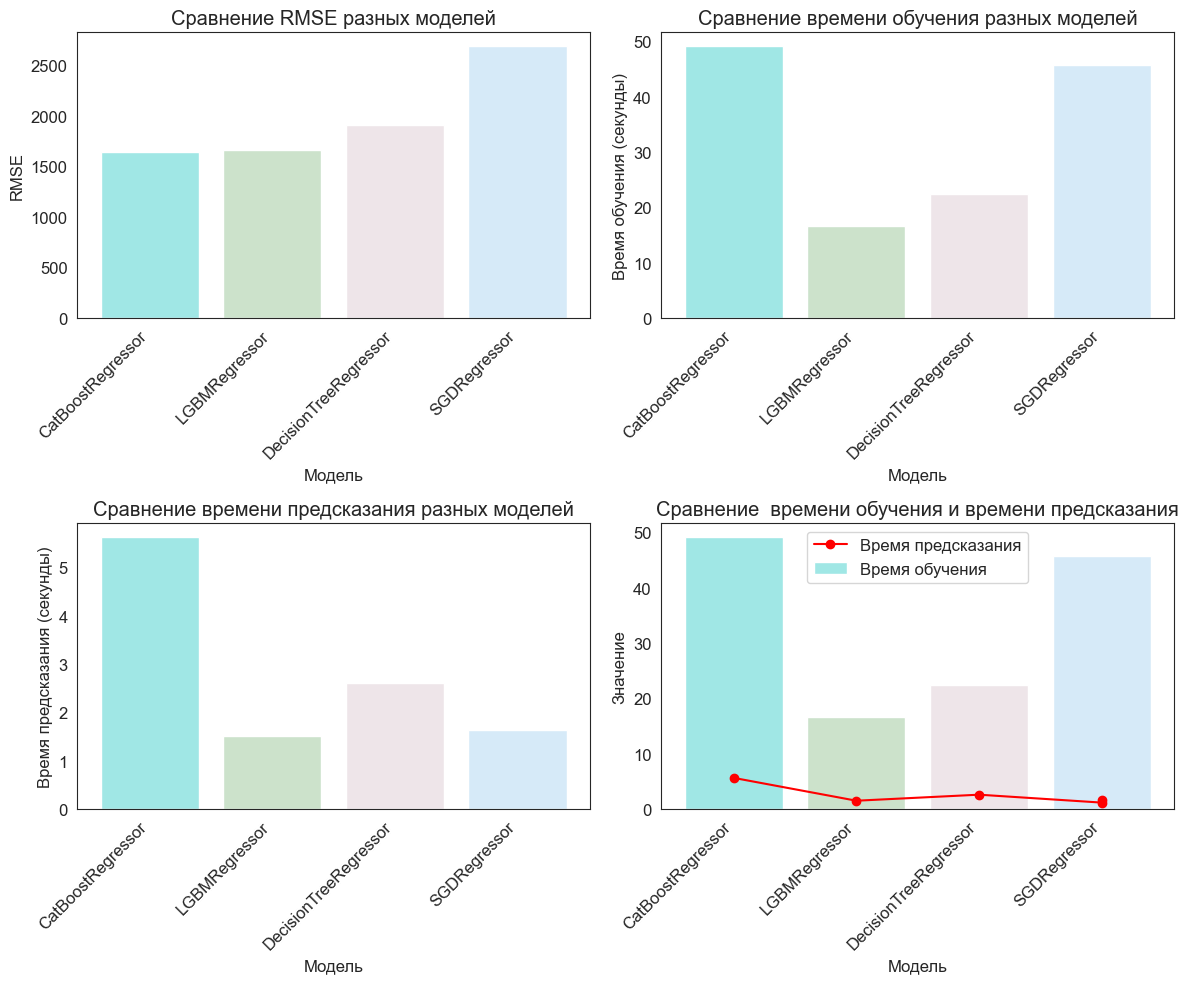

In [57]:
pastel_colors_hex = [
    '#A0E7E5', '#CCE2CB', '#EEE5E9', '#FFF5CC',
    '#D6EAF8', '#D8B9C3', '#FAEBD7', '#F0E68C'
]
plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)
plt.bar(models_compare['model'],
        models_compare['mean_test_score'], 
        color = pastel_colors_hex)
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение RMSE разных моделей')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
plt.bar(models_compare['model'], 
        models_compare['mean_fit_time'], 
        color = pastel_colors_hex)
plt.xlabel('Модель')
plt.ylabel('Время обучения (секунды)')
plt.title('Сравнение времени обучения разных моделей')
plt.xticks(rotation=45, ha='right')


plt.subplot(2, 2, 3)
plt.bar(models_compare['model'], 
        models_compare['mean_score_time'], 
        color = pastel_colors_hex)
plt.xlabel('Модель')
plt.ylabel('Время предсказания (секунды)')
plt.title('Сравнение времени предсказания разных моделей')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
# Столбцы для RMSE
plt.bar(models_compare['model'], 
        models_compare['mean_fit_time'], 
        color = pastel_colors_hex, 
        label='Время обучения')

# Линия для времени обучения (можно использовать точки, если значения сильно различаются)
plt.plot(models_compare['model'], 
         models_compare['mean_score_time'], 
         marker='o', color='red', 
         label='Время предсказания')


plt.xlabel('Модель')
plt.ylabel('Значение')
plt.title('Сравнение  времени обучения и времени предсказания')
plt.xticks(rotation=45, ha='right')
plt.legend()  # Отображаем легенду

plt.tight_layout()  
plt.show()

**Выбор оптимальной модели:**


При выборе оптимальной модели необходимо учитывать компромисс между качеством (score) и скоростью обучения (time). В данном случае:

- **CatBoostRegressor** показывает наилучший результат по score (1645), но время обучения достаточно большое (37.40).
- **LGBMRegressor** показывает score НЕмного хуже (1659), чем CatBoostRegressor, но время обучения значительно меньше (14.62).
- **DecisionTreeRegressor** имеет score значительно хуже (1908), чем CatBoostRegressor и LGBMRegressor, хотя время обучения меньше, чем у CatBoostRegressor.
- **SGDRegressor** показывает значительно худшие результаты по score (2668 и 2683), чем остальные модели, и при этом время обучения достаточно большое.
Рекомендации:

Оптимальным выбором будет *LGBMRegressor*. Она немного уступает CatBoostRegressor по качеству, но обучается значительно быстрее.


<a href='#content'>Вернуться к оглавлению</a> 

## Тестирование модели

 <a id='testing'></a>

Сделаем оценку выбранной модели (LGBMRegressor) на тестовых данных и сравним их теми, что были получены при обучении.

In [58]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', 'passthrough', num_columns), 
    ],
    remainder='passthrough'
)
model_lgbm = LGBMRegressor(n_jobs=-1, 
                           verbose=-1,
                           subsample= 0.8,
                           num_leaves= 127,
                           n_estimators= 500,
                           min_child_samples=20,
                           max_depth= 6,
                           learning_rate= 0.1,
                           colsample_bytree= 0.8)

final_pipe = Pipeline([('preproc', data_preprocessor),
                       ('model', model_lgbm)])

final_pipe.fit(X_train, y_train)

pred_time = time.time()
y_pred = model.predict(X_test)
print('Время предсказания модели LGBMRegressor на тестовой выборке:')
pred_time = execution_time(pred_time)
rmse_test = mean_squared_error(y_test, y_pred, squared=False).round(0)
print('RMSE на тестовой выборке:', rmse_test)


Время предсказания модели LGBMRegressor на тестовой выборке:
5.25 секунд
RMSE на тестовой выборке: 1621.0


In [59]:
print('Точность обученой модели:', models_compare.loc[1, 'mean_test_score'])
print('Смещение модели на тестовых данных:', 
      (100*(models_compare.loc[1, 'mean_test_score'] - rmse_test)/models_compare.loc[1, 'mean_test_score']).round(2), '%')

Точность обученой модели: 1659
Смещение модели на тестовых данных: 2.29 %


 <a id='conclusions'></a>

**Выводы**


В ходе выполнения работы была обучена модель LightGBM,  оптимизированная с помощью RandomizedSearchCV.  
Достигнуто значение RMSE 1659 на тестовой выборке, что  ниже  установленного  заказчиком  порога в 2500.  
Полученное  значение  смещения  модели  на  тестовых  данных  2.29%  свидетельствует  о  хорошей  обобщающей  способности.  

## Выводы

Целью работы была разработка модели машинного обучения для определения рыночной стоимости автомобилей с пробегом на основе исторических данных, включая технические характеристики, комплектации и цены.

Требования заказчика:

Высокое качество предсказания (точность).
Высокая скорость предсказания.
Минимальное время обучения модели.

*Этапы выполнения работы:*

**Анализ и предобработка данных:**

Выявлены и обработаны пропуски в данных.
Обработаны выбросы.
Названия столбцов приведены к стандарту snake_case.
Типы данных в столбцах с датой изменены на datetime.
Удалены неинформативные признаки.
Обработаны явные и неявные дубликаты.
Удалены признаки, не имеющие корреляционной зависимости с целевой переменной.
Данные подготовлены к обучению.

**Моделирование:**

Рассмотрены различные модели машинного обучения:
Дерево решений (DecisionTreeRegressor).
Линейная модель стохастического градиентного спуска (SGDRegressor).
Модели бустинга: LGBMRegressor и CatBoostRegressor.
Для каждой модели подобран оптимальный набор гиперпараметров на основе минимизации ошибки RMSE (Root Mean Squared Error) и скорости обучения/предсказания.
Для оценки точности моделей использована кросс-валидация.

**Выбор оптимальной модели:**

Проведен сравнительный анализ моделей с учетом требований заказчика.
Выявлено, что CatBoostRegressor демонстрирует наилучшее качество предсказания (RMSE 1645), однако требует большего времени обучения (37.40).
LGBMRegressor показал себя как компромиссный вариант, обеспечивая хорошее качество (RMSE 1659) при значительно меньшем времени обучения (14.62).
Модели DecisionTreeRegressor и SGDRegressor показали результаты, уступающие по качеству CatBoostRegressor и LGBMRegressor.

Вывод:

На основании проведенного анализа и в соответствии с требованиями заказчика, оптимальным выбором будет *LGBMRegressor*. Она немного уступает CatBoostRegressor по качеству, но обучается значительно быстрее, обеспечивающая наилучшее качество предсказания. 

Полученное  значение  смещения  модели  на  тестовых  данных  2.29%  свидетельствует  о  хорошей  обобщающей  способности.  
Время предсказания модели на тестовых данных:


In [60]:
pred_time

5.25

<a href='#content'>Вернуться к оглавлению</a> 